In [1]:
import random
import os
import numpy as np
import cv2  # Importing cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from keras.models import Model
import keras.backend as K
import matplotlib.pyplot as plt

In [2]:
# Directory
train_data_dir = '/Users/rishabhsolanki/Desktop/Machine learning/ios/Data/train_data'


In [3]:
# Image dimensions
img_width, img_height = 150, 150
batch_size = 10

In [4]:
def create_pairs_from_dir(directory, positive_samples=True):
    '''Utility to create image pairs and their labels'''
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and not f.startswith('.')]
    paired_images = []
    
    if positive_samples:
        # Positive pairs
        for i in range(len(image_files) - 1):
            for j in range(i + 1, len(image_files)):
                paired_images.append((os.path.join(directory, image_files[i]), os.path.join(directory, image_files[j]), 1))
    else:
        # Negative pairs
        # Filtering out hidden directories or files
        other_dirs = [dir_ for dir_ in os.listdir(os.path.dirname(directory)) if not dir_.startswith('.') and dir_ != os.path.basename(directory)]
        
        # Assuming there's only one other directory, so directly using other_dirs[0]
        other_images_dir = os.path.join(os.path.dirname(directory), other_dirs[0])
        other_images = [f for f in os.listdir(other_images_dir) if os.path.isfile(os.path.join(other_images_dir, f))]
        
        for i in range(len(image_files)):
            paired_images.append((os.path.join(directory, image_files[i]), os.path.join(other_images_dir, random.choice(other_images)), 0))
    
    return paired_images


In [5]:
me_pairs = create_pairs_from_dir(os.path.join(train_data_dir, "me"))
not_me_pairs = create_pairs_from_dir(os.path.join(train_data_dir, "not_me"), positive_samples=False)

all_pairs = me_pairs + not_me_pairs
random.shuffle(all_pairs)

In [6]:
# Split pairs into training and validation
val_split = 0.2
num_val = int(val_split * len(all_pairs))
train_pairs = all_pairs[:-num_val]
val_pairs = all_pairs[-num_val:]

In [7]:
# Use these pairs in a custom generator to feed into the Siamese network
def pair_generator(pairs, batch_size):
    while True:
        idxs = np.random.randint(0, len(pairs), batch_size)
        batch_pairs = [pairs[i] for i in idxs]
        X1 = []
        X2 = []
        y = []
        
        for pair in batch_pairs:
            img1 = plt.imread(pair[0])
            img2 = plt.imread(pair[1])
            
            # Resize if not already
            img1 = cv2.resize(img1, (img_width, img_height))
            img2 = cv2.resize(img2, (img_width, img_height))
            
            X1.append(img1)
            X2.append(img2)
            y.append(float(pair[2]))
        
        yield [np.array(X1), np.array(X2)], np.array(y)

In [8]:
train_gen = pair_generator(train_pairs, batch_size)
val_gen = pair_generator(val_pairs, batch_size)


In [9]:

# Siamese Network Model
def create_base_model(input_shape):
    """Base network to be shared (eq. to feature extraction).
    """
    input_tensor = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), use_bias=False, kernel_initializer='uniform')(input_tensor)
    x = Activation('relu')(x)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(32, (3, 3), use_bias=False, kernel_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2, 2)(x)

    x = Conv2D(64, (3, 3), use_bias=False, kernel_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_initializer='uniform')(x)
    return Model(input_tensor, x)

In [10]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


In [11]:
input_shape = (150, 150, 3)
base_network = create_base_model(input_shape)


In [12]:
# Create the left and right inputs and their embeddings
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
embedding_a = base_network(input_a)
embedding_b = base_network(input_b)


In [13]:
# Calculate the distance between the two embeddings
distance = Dense(1, activation='sigmoid')(Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))([embedding_a, embedding_b]))

In [14]:
# Construct the Siamese network model
siamese_net = Model(inputs=[input_a, input_b], outputs=distance)

In [15]:
def penalized_binary_crossentropy(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Casting y_true to float32
    binary_crossentropy = K.binary_crossentropy(y_true, y_pred)
    correct_preds = K.equal(y_true, K.round(y_pred))
    penalty_tensor = K.ones_like(y_true)
    penalty_tensor = K.switch(correct_preds, penalty_tensor, 1.5 * penalty_tensor)
    return binary_crossentropy * penalty_tensor



In [16]:
siamese_net.compile(optimizer='adam', loss=penalized_binary_crossentropy, metrics=['accuracy'])


In [17]:
siamese_net.fit(
    train_gen,
    steps_per_epoch=len(train_pairs) // batch_size,
    epochs=15,
    validation_data=val_gen,
    validation_steps=len(val_pairs) // batch_size
)


Epoch 1/15
72/72 [==============================] - 15s 202ms/step - loss: 0.4516 - accuracy: 0.9514 - val_loss: 0.3557 - val_accuracy: 0.9778
Epoch 2/15
72/72 [==============================] - 14s 197ms/step - loss: 0.2669 - accuracy: 0.9486 - val_loss: 0.2758 - val_accuracy: 0.9722
Epoch 3/15
72/72 [==============================] - 15s 208ms/step - loss: 0.2346 - accuracy: 0.9611 - val_loss: 0.2345 - val_accuracy: 0.9722
Epoch 4/15
72/72 [==============================] - 14s 199ms/step - loss: 0.1903 - accuracy: 0.9667 - val_loss: 0.3484 - val_accuracy: 0.9278
Epoch 5/15
72/72 [==============================] - 14s 196ms/step - loss: 0.1619 - accuracy: 0.9653 - val_loss: 0.2869 - val_accuracy: 0.9278
Epoch 6/15
72/72 [==============================] - 13s 189ms/step - loss: 0.2735 - accuracy: 0.9583 - val_loss: 0.8981 - val_accuracy: 0.8222
Epoch 7/15
72/72 [==============================] - 14s 189ms/step - loss: 0.1253 - accuracy: 0.9764 - val_loss: 0.2270 - val_accuracy: 0.9833

In [18]:
siamese_net.save('saved_model/my_model')  # This will save the model in TensorFlow format


INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [19]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.saved_model.load('saved_model/my_model')

# Display all output tensor names
for signature_key in loaded_model.signatures:
    outputs = loaded_model.signatures[signature_key].structured_outputs
    for output_key in outputs:
        print(output_key, ":", outputs[output_key].name)


dense_1 : dense_1


In [20]:
import coremltools

In [ ]:
coreml_model = coremltools.convert('saved_model/my_model', source='tensorflow')


In [ ]:
coreml_model = coremltools.convert(
    'saved_model/my_model',  
    source='tensorflow',     
    inputs=[
        coremltools.ImageType(name='input_8', shape=(1, 150, 150, 3)),
        coremltools.ImageType(name='input_9', shape=(1, 150, 150, 3))
    ],
    outputs=[coremltools.TensorType()]
)


In [ ]:
coreml_model.save('your_model_name.mlmodel')


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten, Dropout
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import coremltools as ct  # Ensure coremltools is installed
import tensorflow as tf

In [ ]:
spec = ct.utils.load_spec('your_model_name.mlmodel')
builder = ct.models.neural_network.NeuralNetworkBuilder(spec=spec)

In [ ]:
 # Inspect the last few layers
print(builder.inspect_layers(last=10))

In [ ]:
# Make the last two dense layers updatable
builder.make_updatable(['StatefulPartitionedCall/model_5/dense_5/BiasAdd' , 'StatefulPartitionedCall/model_5/model_4/dense_4/BiasAdd_1']) 


In [ ]:
# Retrieve name of the output of the last layer
last_layer_output = builder.spec.neuralNetwork.layers[-1].output[0]

In [ ]:
# Add the softmax layer
builder.add_softmax(name='SoftmaxLayer', input_name=last_layer_output, output_name='output1')

In [ ]:
from coremltools.models.neural_network import NeuralNetworkBuilder, SgdParams

In [ ]:
# Set the loss and optimizer
builder.set_categorical_cross_entropy_loss(name='lossLayer', input='output1')  # 'output1' is the output of the softmax layer
builder.set_sgd_optimizer(SgdParams(lr=0.005, batch=1))
builder.set_epochs(3)

In [ ]:
# Save the updated model
updatable_model = ct.models.MLModel(spec)
updatable_model.save('/Users/rishabhsolanki/Desktop/Machine learning/ios/core models_python')

In [60]:
# Predictions
val_images, val_labels = next(val_gen)
cnn_predictions = siamese_net.predict(val_images)

1/1 [==============================] - 0s 32ms/step


In [61]:
# Display Results
print("True Labels:    ", val_labels)
print("CNN Predictions:", cnn_predictions.flatten())


True Labels:     [1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
CNN Predictions: [9.9998164e-01 2.4627277e-04 9.9967891e-01 9.9974990e-01 1.0000000e+00
 1.0000000e+00 9.9999511e-01 9.9998873e-01 9.9999630e-01 9.9996489e-01]


In [62]:
# Assuming val_images is a tuple of two batches
image_batch1, image_batch2 = val_images

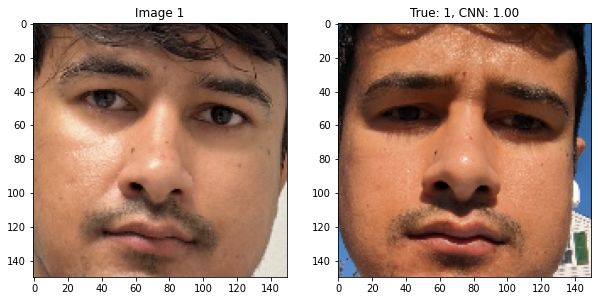

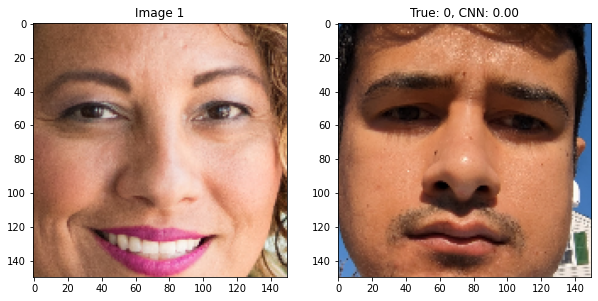

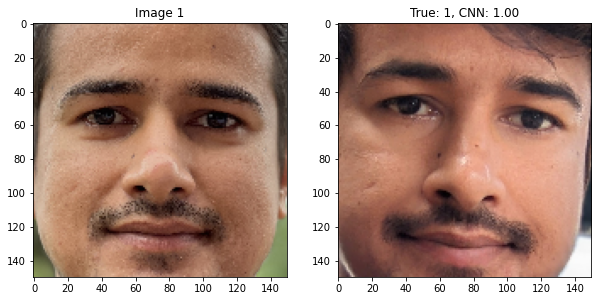

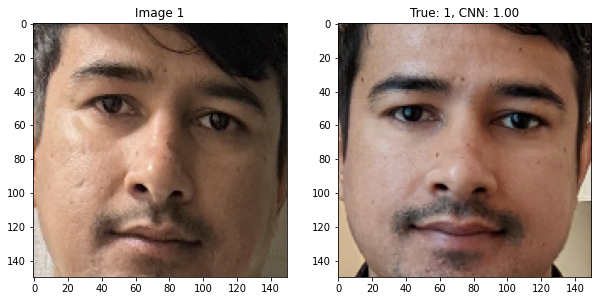

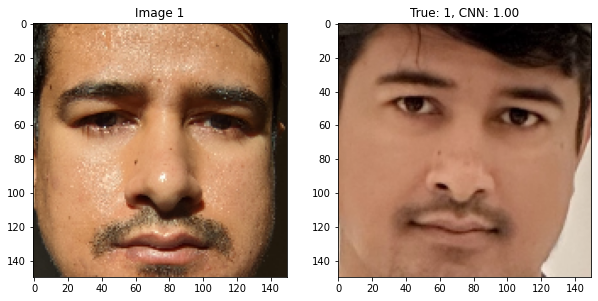

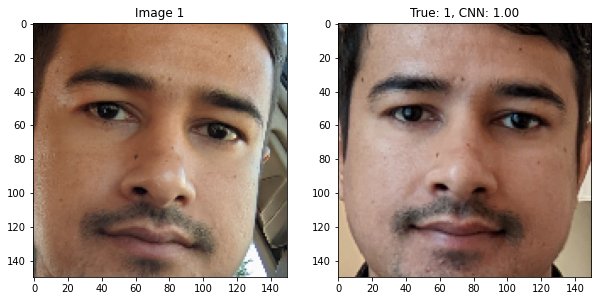

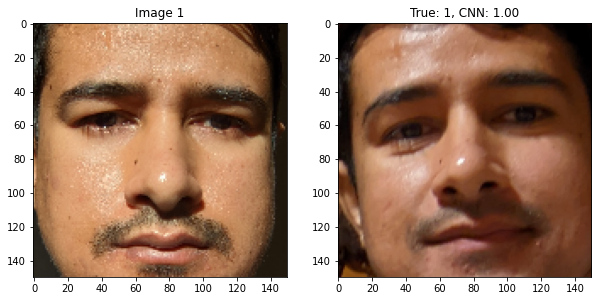

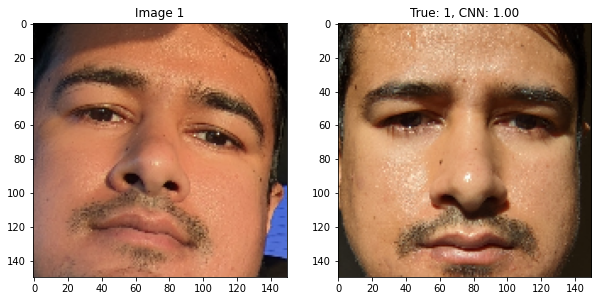

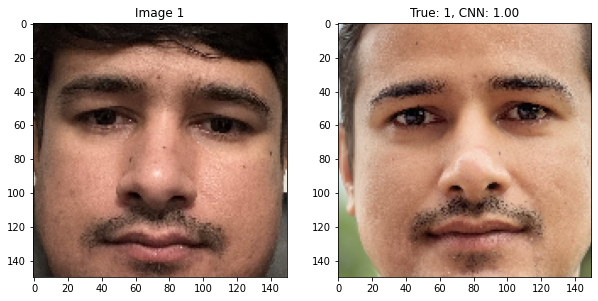

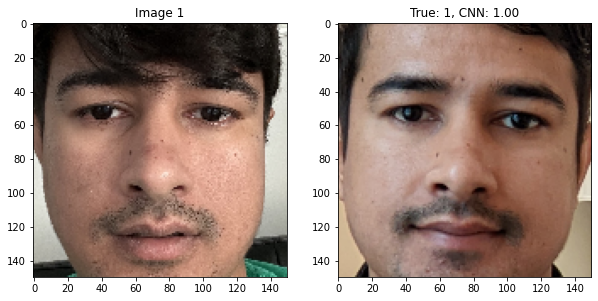

In [63]:
for i in range(len(val_labels)):
    fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
    
    # Displaying the first image from the pair
    axarr[0].imshow(image_batch1[i])
    axarr[0].set_title("Image 1")

    # Displaying the second image from the pair
    axarr[1].imshow(image_batch2[i])
    axarr[1].set_title(f"True: {int(val_labels[i])}, CNN: {cnn_predictions[i][0]:.2f}")
    
    plt.show()




In [64]:
def compute_embeddings(image_paths):
    images = []
    for img_path in image_paths:
        img = plt.imread(img_path)
        img = cv2.resize(img, (img_width, img_height))
        images.append(img)
    return base_network.predict(np.array(images))

me_image_paths = [pair[0] for pair in me_pairs]  # Get all "me" image paths
me_embeddings = compute_embeddings(me_image_paths)

# Compute the average "me" embedding
avg_me_embedding = np.mean(me_embeddings, axis=0)


27/27 [==============================] - 1s 36ms/step


In [74]:
def predict_single_image(img_path, avg_embedding, threshold=55):
    img_embedding = compute_embeddings([img_path])[0]
    dist = np.linalg.norm(img_embedding - avg_embedding)
    
    # Normalizing the distance to a range between 0 and 1
    normalized_dist = dist / (dist + threshold)
    similarity_percentage = (1 - normalized_dist) * 100

    return ("me" if dist < threshold else "not_me", similarity_percentage)

single_img_path = "/Users/rishabhsolanki/Desktop/Machine learning/ios/Data/test_pics/not2.jpg"
result, confidence = predict_single_image(single_img_path, avg_me_embedding)

print(f"The image is classified as: {result} with {confidence:.2f}% confidence.")


1/1 [==============================] - 0s 12ms/step
The image is classified as: not_me with 33.58% confidence.


In [75]:
not_me_image_paths = [pair[0] for pair in not_me_pairs]  # Get all "me" image paths

# Assuming you have a variable `not_me_image_paths` that has the paths for the "not_me" images.
all_image_paths = me_image_paths + not_me_image_paths
random.shuffle(all_image_paths)

1/1 [==============================] - 0s 17ms/step


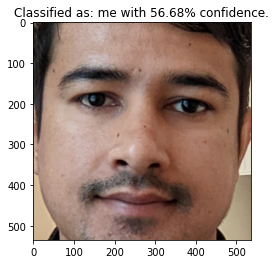

1/1 [==============================] - 0s 14ms/step


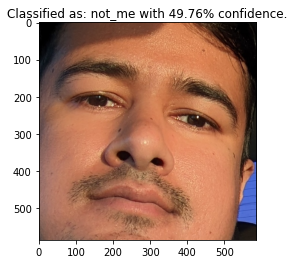

1/1 [==============================] - 0s 14ms/step


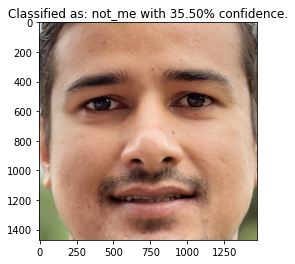

1/1 [==============================] - 0s 14ms/step


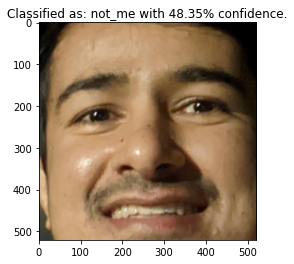

1/1 [==============================] - 0s 14ms/step


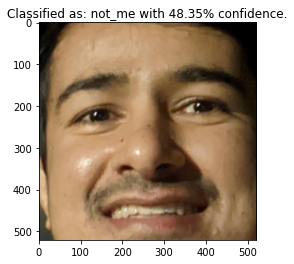

1/1 [==============================] - 0s 20ms/step


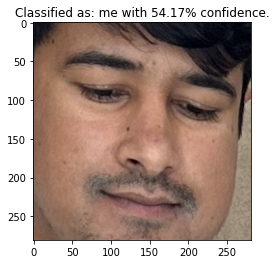

1/1 [==============================] - 0s 13ms/step


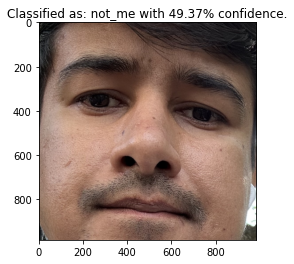

1/1 [==============================] - 0s 12ms/step


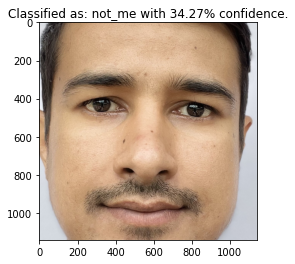

1/1 [==============================] - 0s 18ms/step


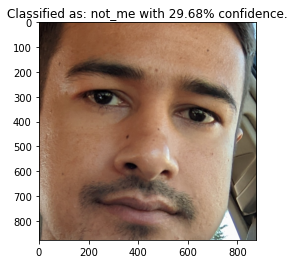

1/1 [==============================] - 0s 20ms/step


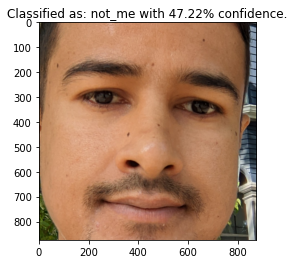

1/1 [==============================] - 0s 30ms/step


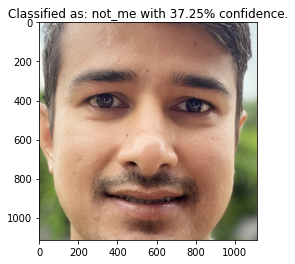

1/1 [==============================] - 0s 14ms/step


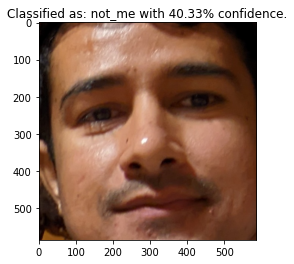

1/1 [==============================] - 0s 13ms/step


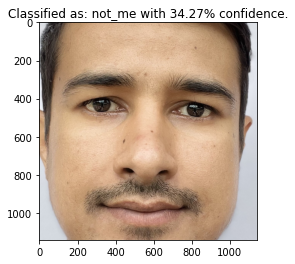

1/1 [==============================] - 0s 17ms/step


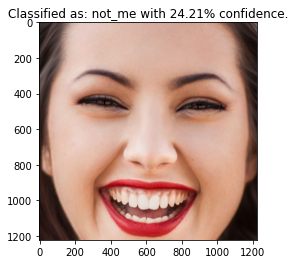

1/1 [==============================] - 0s 13ms/step


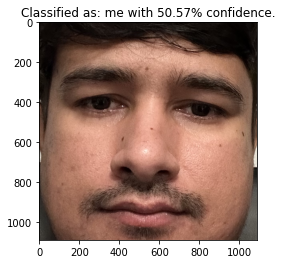

1/1 [==============================] - 0s 12ms/step


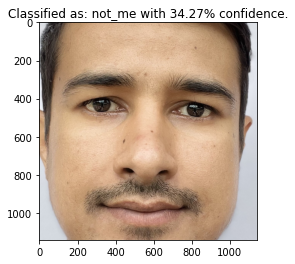

1/1 [==============================] - 0s 13ms/step


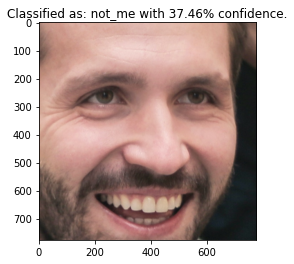

1/1 [==============================] - 0s 12ms/step


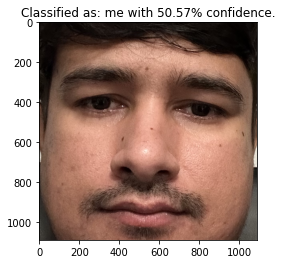

1/1 [==============================] - 0s 19ms/step


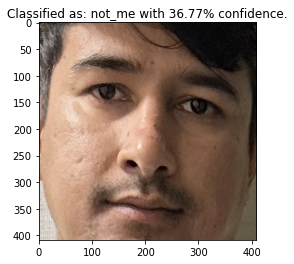

1/1 [==============================] - 0s 15ms/step


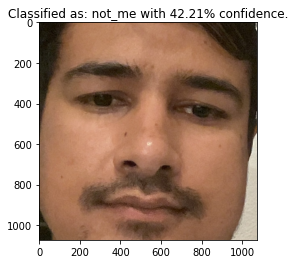

1/1 [==============================] - 0s 34ms/step


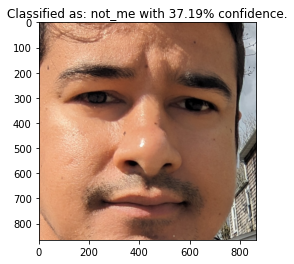

1/1 [==============================] - 0s 13ms/step


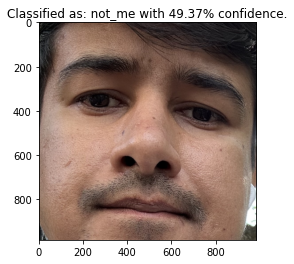

1/1 [==============================] - 0s 14ms/step


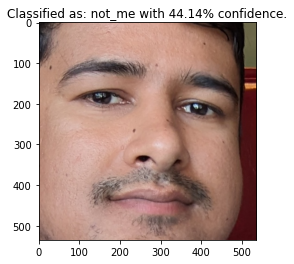

1/1 [==============================] - 0s 16ms/step


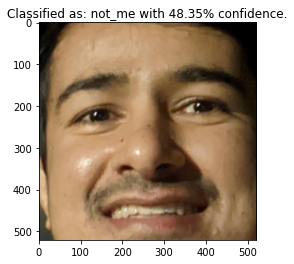

1/1 [==============================] - 0s 17ms/step


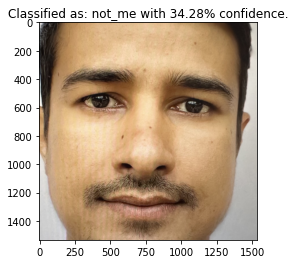

1/1 [==============================] - 0s 14ms/step


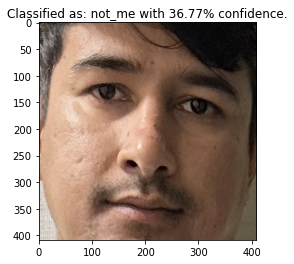

1/1 [==============================] - 0s 13ms/step


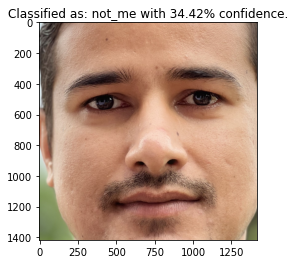

1/1 [==============================] - 0s 13ms/step


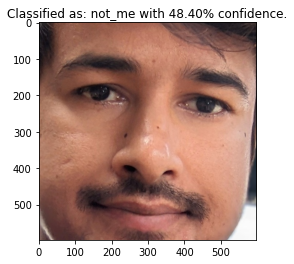

1/1 [==============================] - 0s 14ms/step


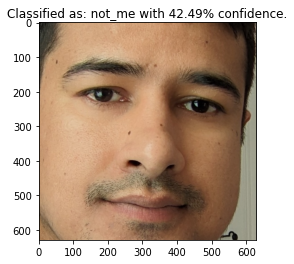

1/1 [==============================] - 0s 46ms/step


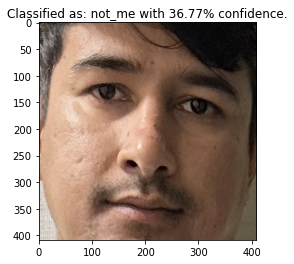

1/1 [==============================] - 0s 14ms/step


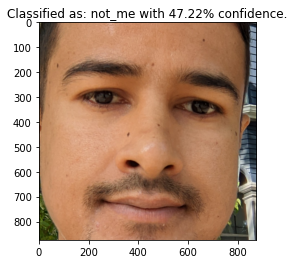

1/1 [==============================] - 0s 13ms/step


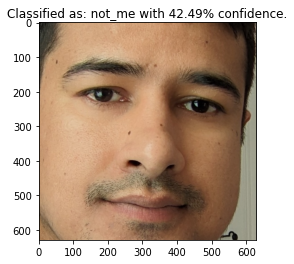

1/1 [==============================] - 0s 18ms/step


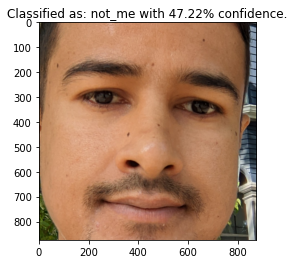

1/1 [==============================] - 0s 16ms/step


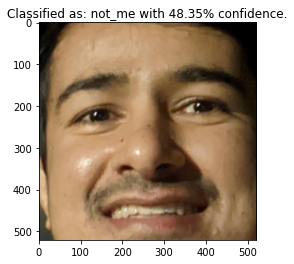

1/1 [==============================] - 0s 13ms/step


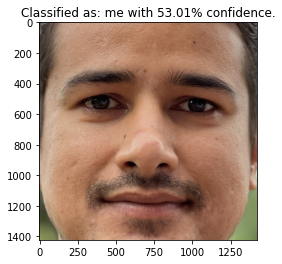

1/1 [==============================] - 0s 18ms/step


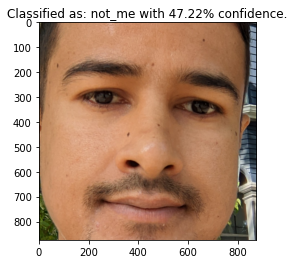

1/1 [==============================] - 0s 34ms/step


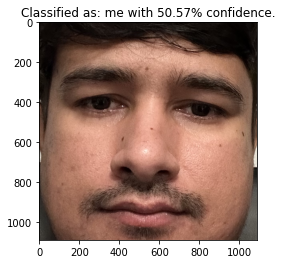

1/1 [==============================] - 0s 14ms/step


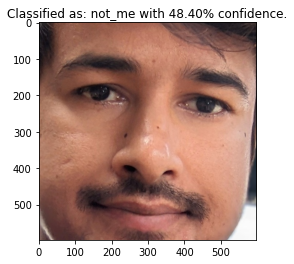

1/1 [==============================] - 0s 13ms/step


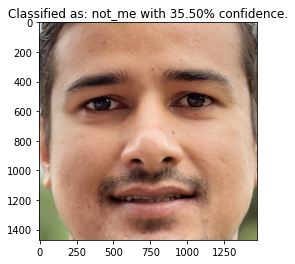

1/1 [==============================] - 0s 42ms/step


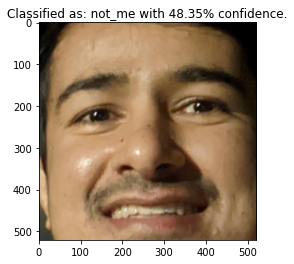

1/1 [==============================] - 0s 45ms/step


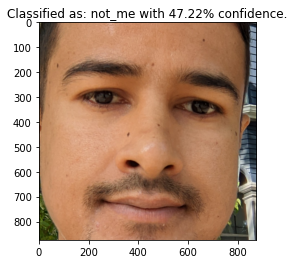

1/1 [==============================] - 0s 34ms/step


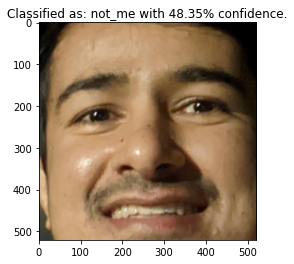

1/1 [==============================] - 0s 36ms/step


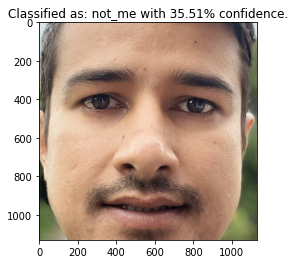

1/1 [==============================] - 0s 15ms/step


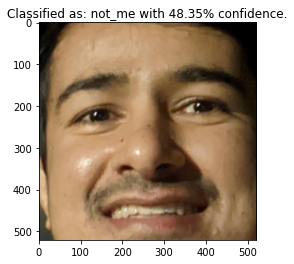

1/1 [==============================] - 0s 14ms/step


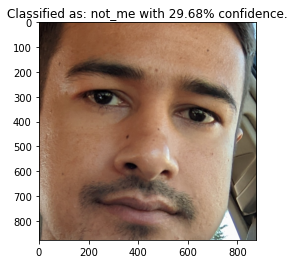

1/1 [==============================] - 0s 19ms/step


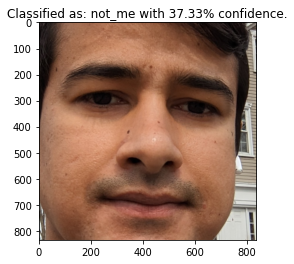

1/1 [==============================] - 0s 17ms/step


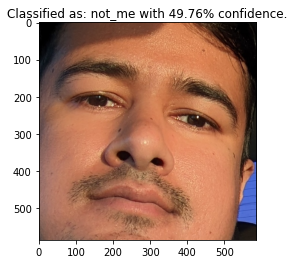

1/1 [==============================] - 0s 14ms/step


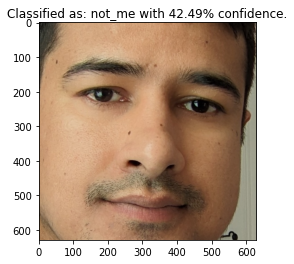

1/1 [==============================] - 0s 46ms/step


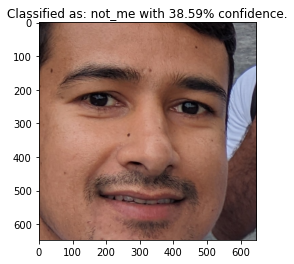

1/1 [==============================] - 0s 52ms/step


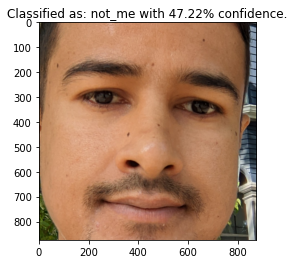

1/1 [==============================] - 0s 13ms/step


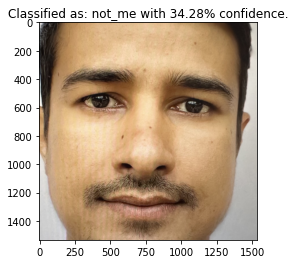

1/1 [==============================] - 0s 51ms/step


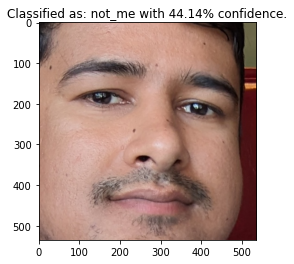

1/1 [==============================] - 0s 32ms/step


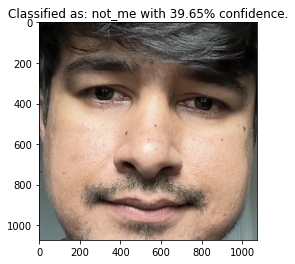

1/1 [==============================] - 0s 33ms/step


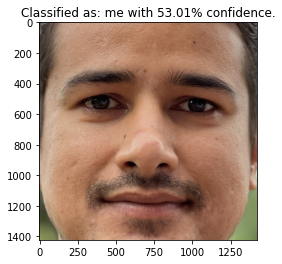

KeyboardInterrupt: 

In [76]:
for img_path in all_image_paths:
    result, confidence = predict_single_image(img_path, avg_me_embedding)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"Classified as: {result} with {confidence:.2f}% confidence.")
    plt.show()